# ANN to Predict Subject
Ok so this is working pretty good. As proof of robustness, can we shuffle the labels?

If we shuffle and results are bad, then the fingerprinting is robust. If not then :sadface:


Setup: Javascript and ipynb stuff

In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [25]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import random

In [14]:
path=pathlib.Path('/media/tris/tris_files/DEAP_dataset/DMD')
path

PosixPath('/media/tris/tris_files/DEAP_dataset/DMD')

## Load Original Data Labels

In [15]:
path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s01.dat'
df_read = pickle.load(open(path, 'rb'), encoding='latin1')
labels=df_read['labels']
df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
df=df_tmp
for n in range (2,10):
    path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s0'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True)
for n in range (10,33):
    path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True) 

In [16]:
df=df.div(9) #normalize
df.head()

,valence,arousal,dominance,liking
0,0.856667,0.844444,0.766667,0.870000
1,0.900000,0.812222,0.808889,0.941111
2,0.953333,0.837778,1.000000,0.786667
3,0.548889,0.667778,0.680000,0.895556
4,0.773333,0.435556,0.798889,0.672222


## Set filenames and labels

In [17]:
filenames=[]
subject_labels=[]
for n in range (0,9):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=random.randint(1, 32) #RANDOM BABY
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=random.randint(1, 32)
        subject_labels.append(subject_label)
for n in range (9,32):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=random.randint(1, 32)
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=random.randint(1, 32)
        subject_labels.append(subject_label)
df['file_name']=filenames
df['subject_label']=subject_labels
# df=df[['file_name','valence','arousal','dominance','liking']]
df=df[['file_name','subject_label']]
df.tail()

,file_name,subject_label
1275,S32T36,5
1276,S32T37,18
1277,S32T38,23
1278,S32T39,2
1279,S32T40,32


In [18]:
# for i in range(1,33):
#     for ii in range(1,41):
#         os.rename(r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/T'+str(ii)+'S'+str(i)+".png",r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/S'+str(i)+'T'+str(ii)+".png")

In [19]:
# from PIL import Image

# for i in range (0,1280):
    
#     im = Image.open(r"/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/"+str(df.file_name[i])+".png")
#     im1=im.crop((0,0,1450,1030))
#     im1.save("/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps_re/"+str(df.file_name[i])+".png")

In [20]:
path=pathlib.Path('/media/tris/tris_files/DEAP_dataset/DMD')
path

PosixPath('/media/tris/tris_files/DEAP_dataset/DMD')

In [21]:
df.to_csv(path/'labels_proc_SHUFFLE.csv', index=False)

In [22]:
df = pd.read_csv(path/'labels_proc_SHUFFLE.csv') #load labels
df.tail()

,file_name,subject_label
1275,S32T36,5
1276,S32T37,18
1277,S32T38,23
1278,S32T39,2
1279,S32T40,32


## Data loader

In [28]:
src = (ImageList.from_csv(path, 'labels_proc_SHUFFLE.csv', folder='heatmaps_40', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['subject_label'],label_cls=CategoryList)
#        .label_from_df(cols=['valence','arousal','dominance','liking'],label_cls=FloatList)
       .transform()
       .databunch(bs=4).normalize())

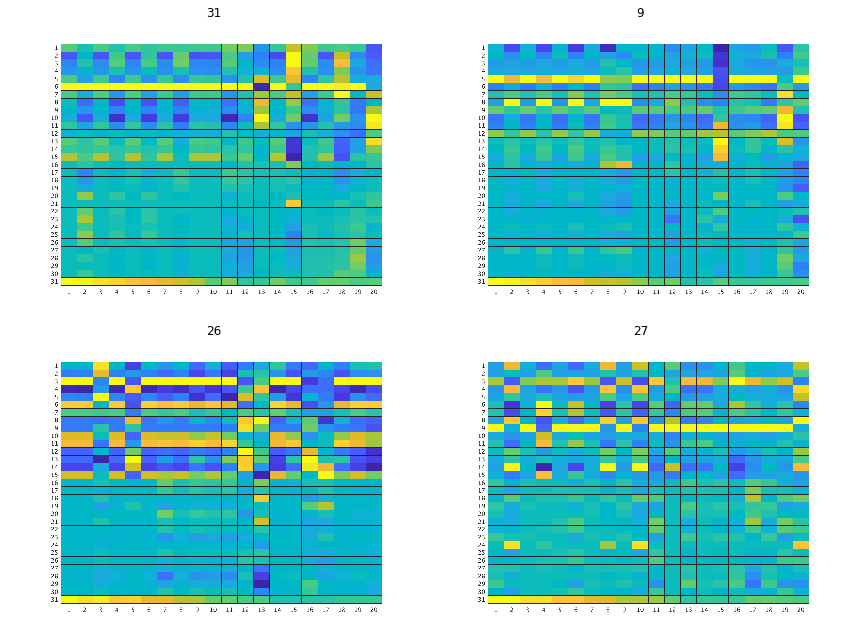

In [29]:
src.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [30]:
learn = cnn_learner(src, models.resnet18, metrics=accuracy)

In [31]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 521, 729]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 521, 729]       128        True      
______________________________________________________________________
ReLU                 [64, 521, 729]       0          False     
______________________________________________________________________
MaxPool2d            [64, 261, 365]       0          False     
______________________________________________________________________
Conv2d               [64, 261, 365]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 261, 365]       128        True      
______________________________________________________________________
ReLU                 [64, 261, 365]       0          False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


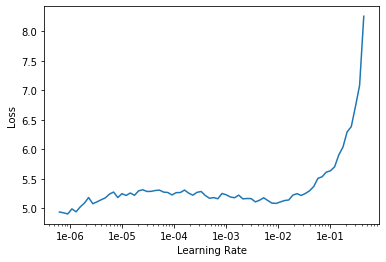

In [32]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [33]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,5.603969,5.890803,0.046875,01:13
1,5.348623,8.650854,0.003906,01:14
2,4.153504,13.025522,0.023438,01:14
3,3.622413,4.108632,0.042969,01:14
4,3.245018,3.749077,0.031250,01:15


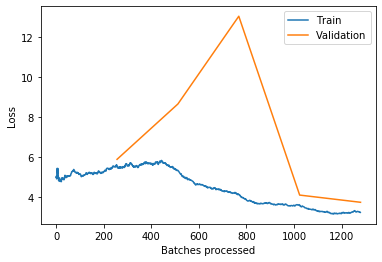

In [34]:
learn.recorder.plot_losses()

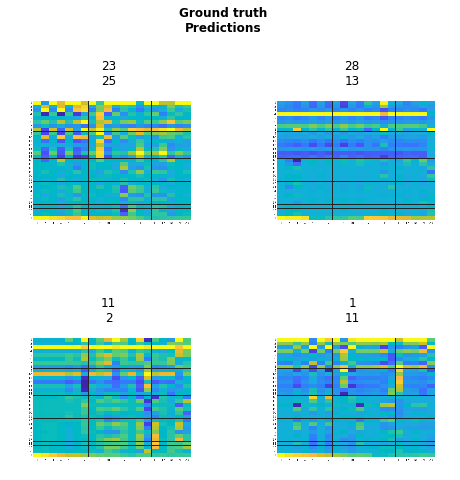

In [35]:
learn.show_results()

## Train the whole network

In [22]:
# learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot()

In [16]:
# lr = 8e-6
# learn.fit_one_cycle(5, slice(lr))

## Interpret and Results

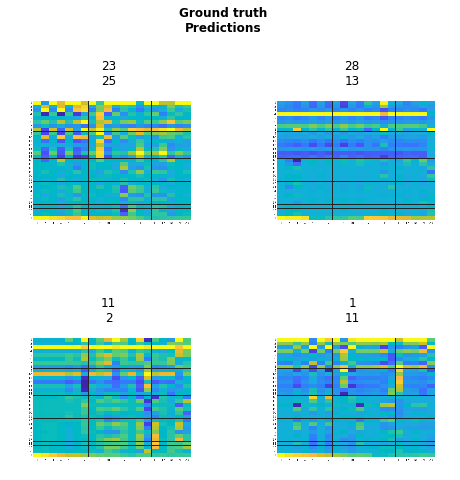

In [38]:
learn.show_results()

In [39]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

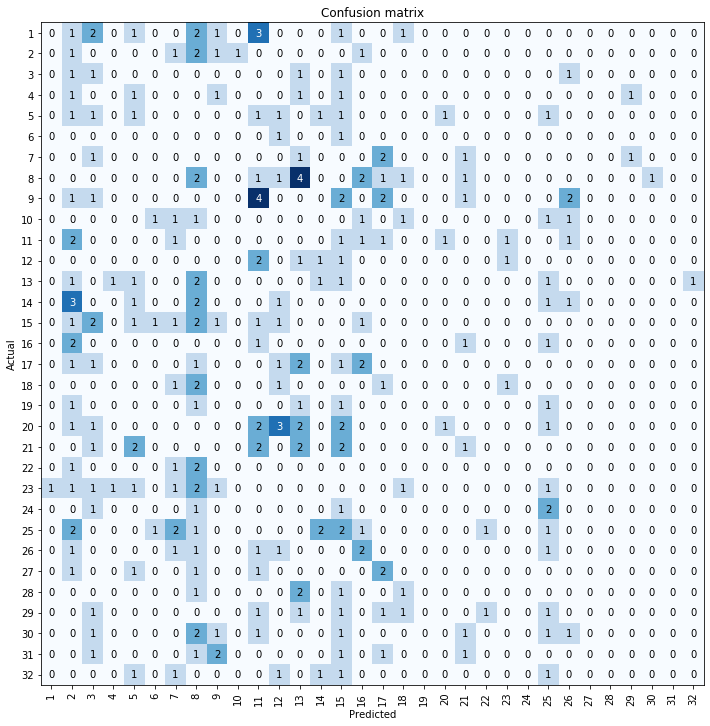

In [40]:
interp.plot_confusion_matrix(figsize=(10,10))

![Alt Text](https://i.imgur.com/rKE3uNd.gif)